In [286]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from matplotlib import pyplot as plt
import xgboost as xgb
from radiomics import featureextractor
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from typing import List, Dict

In [ ]:
BASE_DIR = "10159290"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
MASKS_DIR = os.path.join(BASE_DIR, "masks")
OVERVIEW_CSV  = os.path.join(BASE_DIR, "overview.csv")
GRADINGS_CSV  = os.path.join(BASE_DIR, "radiological_gradings.csv")

In [13]:
overview_df = pd.read_csv(OVERVIEW_CSV)
print(overview_df)

    new_file_name  num_vertebrae  num_discs sex  birth_date    subset  \
0            1_t1              7          7  F          NaN  training   
1            1_t2              7          7  F          NaN  training   
2           10_t1              7          7   F         NaN  training   
3           10_t2              7          7   F         NaN  training   
4          100_t1              8          8   F         NaN  training   
..            ...            ...        ...  ..         ...       ...   
442         97_t2              7          7   M         NaN  training   
443         98_t1              8          8   F        30.0  training   
444         98_t2              7          7   F        30.0  training   
445   98_t2_SPACE              7          8   F        30.0  training   
446         99_t2              8          8   F         NaN  training   

    AngioFlag  BodyPartExamined  DeviceSerialNumber  EchoNumbers  ...  \
0         NaN            LSPINE                 Na

In [14]:
gradings_df = pd.read_csv(GRADINGS_CSV)
print(gradings_df)

      Patient  IVD label  Modic  UP endplate  LOW endplate  Spondylolisthesis  \
0           1          1      0            0             0                  0   
1           1          2      0            0             0                  0   
2           1          3      0            0             0                  0   
3           1          4      0            0             0                  0   
4           1          5      0            0             0                  0   
...       ...        ...    ...          ...           ...                ...   
1515      257          2      2            1             1                  0   
1516      257          3      2            1             1                  0   
1517      257          4      2            1             1                  0   
1518      257          5      2            1             1                  0   
1519      257          6      2            1             1                  0   

      Disc herniation  Disc

In [ ]:
# We have nine IVD labels
np.unique(gradings_df.loc[:,"IVD label"])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [86]:
gradings_df.loc[gradings_df["IVD label"] == 9, ]

Patient  IVD label  Modic  UP endplate  LOW endplate  Spondylolisthesis  \
151        23          9      0            0             0                  0   
222        35          9      0            0             0                  0   
394        63          9      0            0             0                  0   
410        65          9      2            1             1                  0   
419        66          9      0            0             0                  0   
840       140          9      0            0             0                  0   
863       143          9      0            0             0                  0   
962       162          9      2            1             1                  0   
1051      177          9      0            0             0                  0   
1082      182          9      2            1             1                  0   
1398      234          9      2            0             0                  0   
1427      241          9      0            0             1                  0   

      Disc herniation  Disc narrowing  Disc bulging  Pfirrman grade  
151                 0               0             0               2  
222                 0               0             0               1  
394                 0               0             0               1  
410                 0               0             1               4  
419                 0               0             0               2  
840                 0               0             0               1  
863                 0               0             0               3  
962                 0               1             1               5  
1051                0               0             0               3  
1082                0               0             0               3  
1398                0               0             0               1  
1427                0               0             0               3

In [17]:
images_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(".mha")])

In [18]:
images_files

['100_t1.mha',
 '100_t2.mha',
 '101_t1.mha',
 '101_t2.mha',
 '104_t1.mha',
 '104_t2.mha',
 '105_t1.mha',
 '105_t2.mha',
 '106_t1.mha',
 '106_t2.mha',
 '107_t1.mha',
 '107_t2.mha',
 '107_t2_SPACE.mha',
 '108_t1.mha',
 '108_t2.mha',
 '109_t1.mha',
 '109_t2.mha',
 '10_t1.mha',
 '10_t2.mha',
 '110_t1.mha',
 '110_t2.mha',
 '110_t2_SPACE.mha',
 '112_t1.mha',
 '112_t2.mha',
 '113_t1.mha',
 '113_t2.mha',
 '115_t1.mha',
 '115_t2.mha',
 '116_t1.mha',
 '116_t2.mha',
 '117_t1.mha',
 '117_t2.mha',
 '118_t1.mha',
 '118_t2.mha',
 '118_t2_SPACE.mha',
 '11_t1.mha',
 '11_t2.mha',
 '11_t2_SPACE.mha',
 '120_t2.mha',
 '121_t1.mha',
 '121_t2.mha',
 '122_t1.mha',
 '122_t2.mha',
 '123_t2.mha',
 '124_t2.mha',
 '125_t1.mha',
 '125_t2.mha',
 '126_t1.mha',
 '127_t1.mha',
 '127_t2.mha',
 '127_t2_SPACE.mha',
 '129_t1.mha',
 '129_t2.mha',
 '129_t2_SPACE.mha',
 '12_t1.mha',
 '12_t2.mha',
 '130_t1.mha',
 '130_t2.mha',
 '131_t1.mha',
 '131_t2.mha',
 '132_t1.mha',
 '133_t1.mha',
 '133_t2.mha',
 '134_t2.mha',
 '136_t1.mh

In [19]:
mask_files = sorted([f for f in os.listdir(MASKS_DIR) if f.endswith(".mha")])

In [20]:
mask_files

['100_t1.mha',
 '100_t2.mha',
 '101_t1.mha',
 '101_t2.mha',
 '104_t1.mha',
 '104_t2.mha',
 '105_t1.mha',
 '105_t2.mha',
 '106_t1.mha',
 '106_t2.mha',
 '107_t1.mha',
 '107_t2.mha',
 '107_t2_SPACE.mha',
 '108_t1.mha',
 '108_t2.mha',
 '109_t1.mha',
 '109_t2.mha',
 '10_t1.mha',
 '10_t2.mha',
 '110_t1.mha',
 '110_t2.mha',
 '110_t2_SPACE.mha',
 '112_t1.mha',
 '112_t2.mha',
 '113_t1.mha',
 '113_t2.mha',
 '115_t1.mha',
 '115_t2.mha',
 '116_t1.mha',
 '116_t2.mha',
 '117_t1.mha',
 '117_t2.mha',
 '118_t1.mha',
 '118_t2.mha',
 '118_t2_SPACE.mha',
 '11_t1.mha',
 '11_t2.mha',
 '11_t2_SPACE.mha',
 '120_t2.mha',
 '121_t1.mha',
 '121_t2.mha',
 '122_t1.mha',
 '122_t2.mha',
 '123_t2.mha',
 '124_t2.mha',
 '125_t1.mha',
 '125_t2.mha',
 '126_t1.mha',
 '127_t1.mha',
 '127_t2.mha',
 '127_t2_SPACE.mha',
 '129_t1.mha',
 '129_t2.mha',
 '129_t2_SPACE.mha',
 '12_t1.mha',
 '12_t2.mha',
 '130_t1.mha',
 '130_t2.mha',
 '131_t1.mha',
 '131_t2.mha',
 '132_t1.mha',
 '133_t1.mha',
 '133_t2.mha',
 '134_t2.mha',
 '136_t1.mh

In [21]:
images_files == mask_files

True

In [136]:
def list_scans(images_dir: str, masks_dir: str) -> pd.DataFrame:
    images_files: List[str] = sorted([f for f in os.listdir(images_dir) if f.endswith(".mha")])
    mask_files = sorted([f for f in os.listdir(MASKS_DIR) if f.endswith(".mha")])
    assert set(images_files) == set(mask_files)
    rows: Dict = []
    for fname in images_files:
        scan_id = fname.replace(".mha", "")
        patient_type:List[str] = scan_id.split("_")
        patient_id: str  = patient_type[0]
        scan_type: str  = patient_type[1]
        if len(patient_type) == 3:
            scan_type = scan_type + patient_type[2]

        rows.append({
            "scan_id": scan_id,
            "patient_id": patient_id,
            "scan_type": scan_type,
            "image_path": os.path.join(images_dir, fname),
            "mask_path": os.path.join(masks_dir, fname)
        })
        df_result_scans: pd.DataFrame  = pd.DataFrame(rows)
        df_result_scans["patient_id"] = df_result_scans["patient_id"].astype(int)
    return df_result_scans.sort_values("patient_id")    

In [134]:
scan_df = list_scans(IMAGE_DIR, MASKS_DIR)
scan_df.head(5)


scan_id  patient_id scan_type                image_path  \
186    1_t1           1        t1  10159290/images/1_t1.mha   
187    1_t2           1        t2  10159290/images/1_t2.mha   
304    2_t2           2        t2  10159290/images/2_t2.mha   
303    2_t1           2        t1  10159290/images/2_t1.mha   
328    3_t2           3        t2  10159290/images/3_t2.mha   

                   mask_path  
186  10159290/masks/1_t1.mha  
187  10159290/masks/1_t2.mha  
304  10159290/masks/2_t2.mha  
303  10159290/masks/2_t1.mha  
328  10159290/masks/3_t2.mha

In [151]:
t2_scans = scan_df.loc[scan_df["scan_type"] == 't2',]

In [143]:
np.unique(t2_scans['scan_type'])

array(['t2'], dtype=object)

In [160]:
t2_scans.loc[t2_scans["patient_id"] == 23,]["mask_path"].iloc[0]

'10159290/masks/23_t2.mha'

In [158]:
t2_scans.iloc[13]

scan_id                           15_t2
patient_id                           15
scan_type                            t2
image_path    10159290/images/15_t2.mha
mask_path      10159290/masks/15_t2.mha
Name: 103, dtype: object

In [165]:
example_mask_path = t2_scans.loc[t2_scans["patient_id"] == 23, "mask_path"].iloc[0]
mask = sitk.ReadImage(example_mask_path)
mask_np = sitk.GetArrayFromImage(mask)
np.unique(mask_np)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 201, 202,
       203, 204, 205, 206, 207, 208, 209], dtype=int16)

In [166]:
example = t2_scans.loc[t2_scans["patient_id"] == 23, :].iloc[0]
example_image_path = example["image_path"]
img = sitk.ReadImage(example_image_path)
img_np = sitk.GetArrayFromImage(img)

print(img_np.shape, mask_np.shape)

(323, 392, 17) (323, 392, 17)


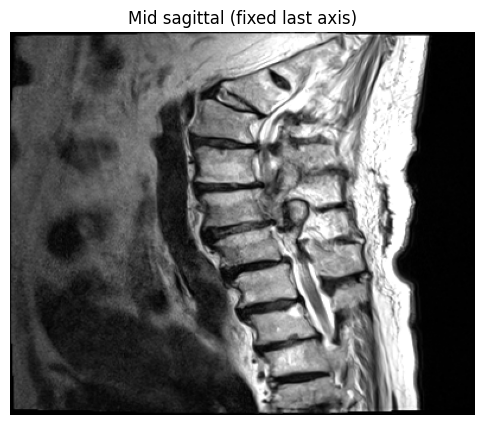

In [ ]:
x = img_np.shape[2] // 2

plt.figure(figsize=(6, 8))
plt.imshow(img_np[:, :, x], cmap="gray")  # shape (486, 384)
plt.axis("off")
plt.title("Mid sagittal (fixed last axis)")
plt.show()

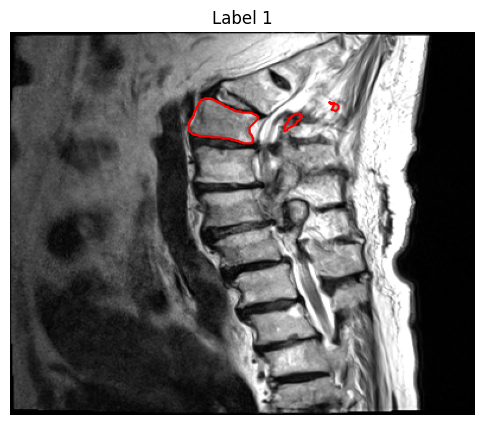

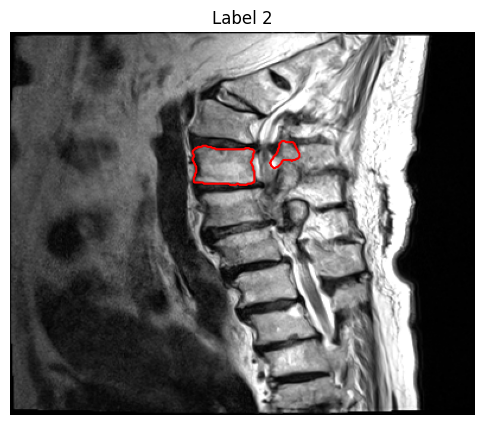

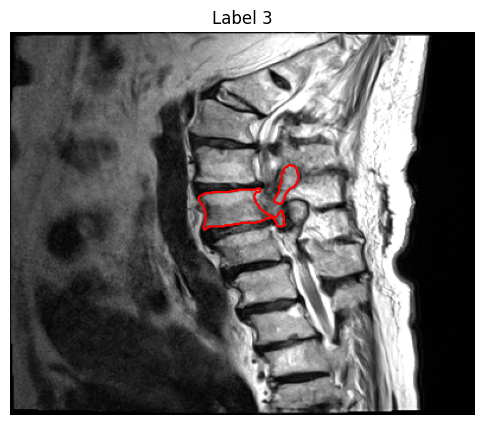

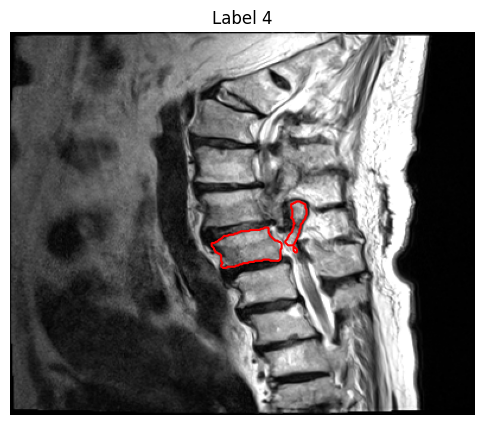

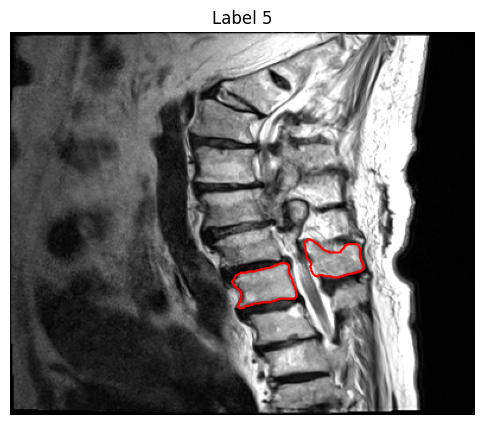

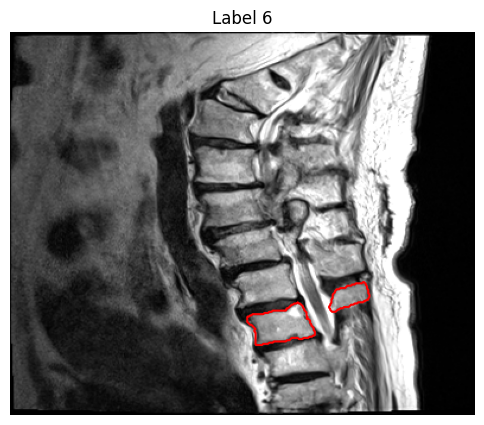

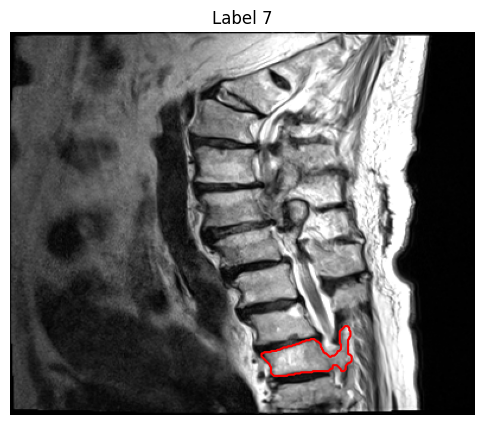

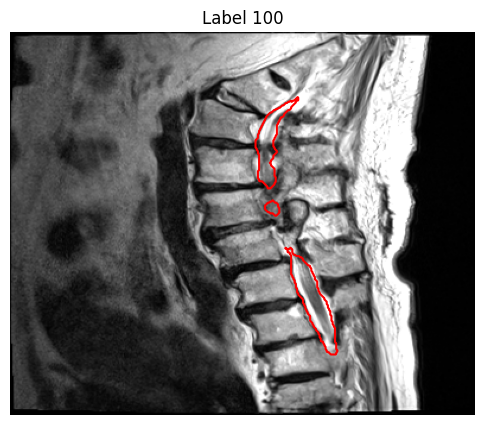

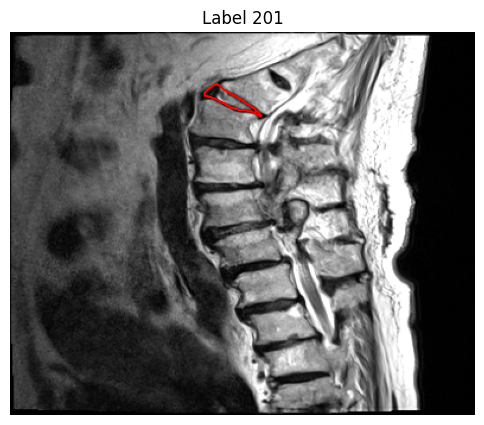

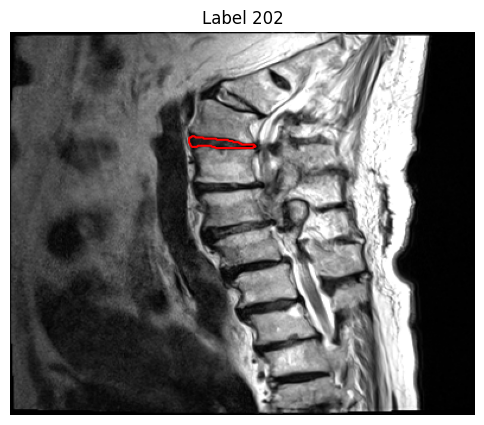

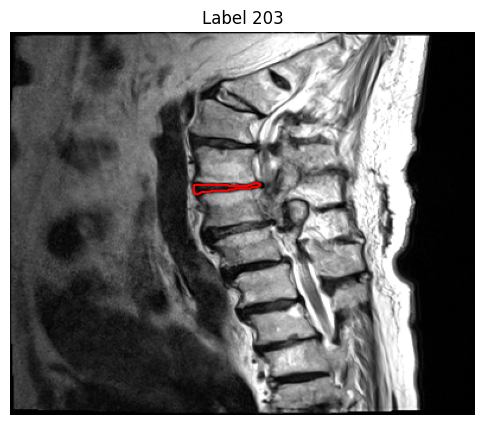

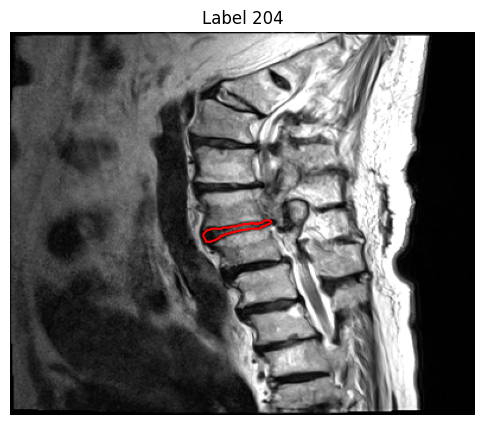

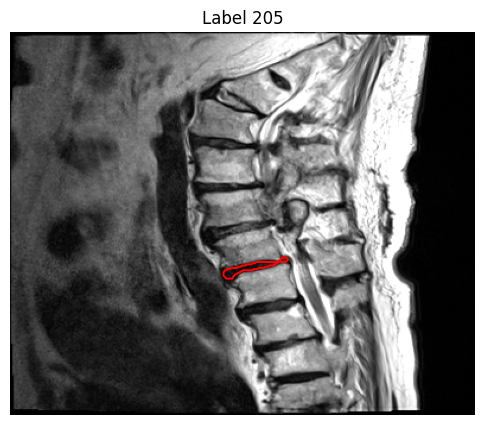

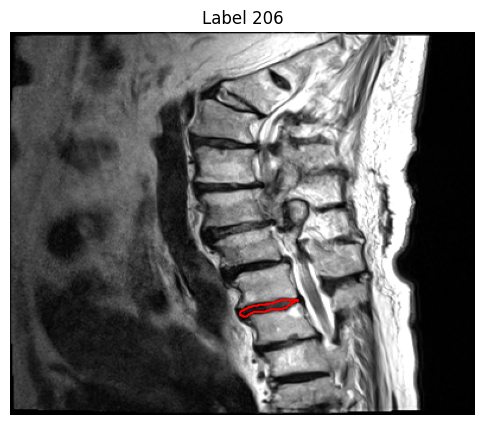

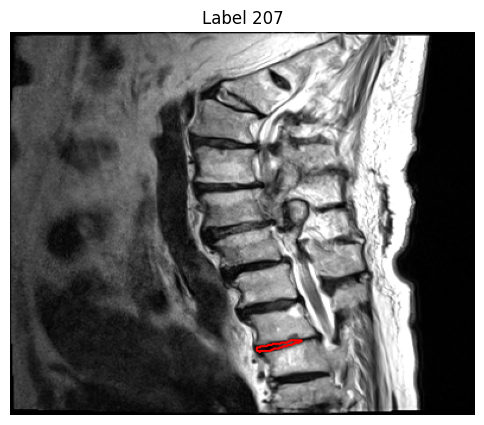

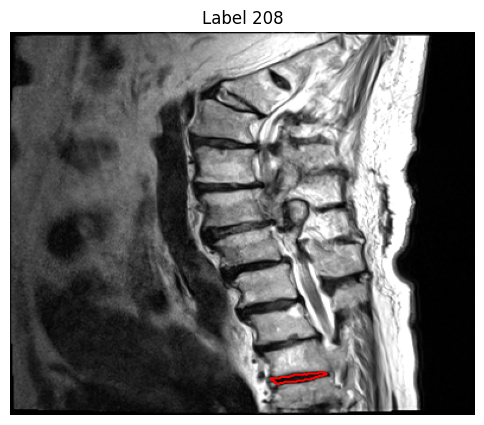

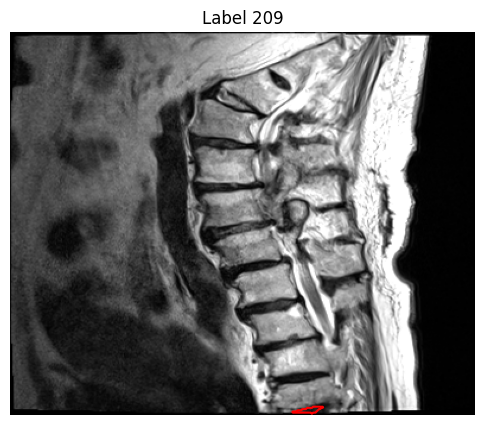

In [168]:
def show_label(label):
    plt.figure(figsize=(6, 8))
    plt.imshow(img_np[:, :, x], cmap="gray")
    plt.contour(mask_np[:, :, x] == label, levels=[0.5], colors="r")
    plt.title(f"Label {label}")
    plt.axis("off")
    plt.show()

for lbl in [1, 2, 3, 4, 5, 6, 7, 100, 201, 202, 203, 204, 205, 206, 207, 208, 209]:
    show_label(lbl)

In [169]:
def load_mask(mask_path):
    mask_img = sitk.ReadImage(mask_path)
    mask_np = sitk.GetArrayFromImage(mask_img)
    return mask_img, mask_np

In [170]:
def compute_label_centroid_z(mask_np, label):
    coords = np.where(mask_np == label)
    if coords[0].size == 0:
        return None
    return float(coords[0].mean())  # axis 0 is superior–inferior


In [171]:
def build_disc_map_for_patient(mask_np, patient_grades):
    # disc labels present in this mask (201..207 etc.)
    disc_labels_present = sorted(
        int(l) for l in np.unique(mask_np) if 200 < l < 300
    )
    if not disc_labels_present:
        return {}

    # centroids to sort discs in order along spine
    centroids = []
    for lbl in disc_labels_present:
        zc = compute_label_centroid_z(mask_np, lbl)
        if zc is not None:
            centroids.append((lbl, zc))

    # sort by z (top→bottom or bottom→top; doesn’t matter as long as consistent)
    centroids_sorted = sorted(centroids, key=lambda x: x[1])
    sorted_disc_labels = [lbl for lbl, _ in centroids_sorted]

    # IVD indices present in gradings for this patient
    ivd_indices = sorted(int(i) for i in patient_grades["IVD label"].unique())

    # map smallest list length
    n = min(len(sorted_disc_labels), len(ivd_indices))
    disc_map = {
        ivd_idx: lbl
        for ivd_idx, lbl in zip(ivd_indices[:n], sorted_disc_labels[:n])
    }
    return disc_map

In [172]:
example = t2_scans.iloc[0]
_, example_mask_np = load_mask(example["mask_path"])
example_grades = gradings_df[gradings_df["Patient"] == example["patient_id"]]
build_disc_map_for_patient(example_mask_np, example_grades)


{1: 201, 2: 202, 3: 203, 4: 204, 5: 205, 6: 206, 7: 207}

In [187]:
params = {
    "binWidth": 25,
    "resampledPixelSpacing": None,
    "interpolator": "sitkBSpline",
    "enableCExtensions": True,
    "featureClass": {
        "firstorder": {},
        "shape": {},
        "glcm": {},
        "glrlm": {},
        "glszm": {},
        "gldm": {},
        "ngtdm": {},
    }
}

extractor = featureextractor.RadiomicsFeatureExtractor(**params)   

In [188]:
def extract_disc_features(image_path, mask_path, disc_label):
    result = extractor.execute(image_path, mask_path, label=disc_label)
    # keep only feature entries
    features = {
        k: float(v)
        for k, v in result.items()
        if k.startswith("original_")  # filter diagnostics etc.
    }
    return features


In [183]:
gradings_df[gradings_df["Patient"] == 1]

Patient  IVD label  Modic  UP endplate  LOW endplate  Spondylolisthesis  \
0        1          1      0            0             0                  0   
1        1          2      0            0             0                  0   
2        1          3      0            0             0                  0   
3        1          4      0            0             0                  0   
4        1          5      0            0             0                  0   
5        1          6      0            0             1                  0   
6        1          7      0            0             0                  0   

   Disc herniation  Disc narrowing  Disc bulging  Pfirrman grade  
0                0               1             1               3  
1                0               0             1               3  
2                0               1             1               3  
3                0               1             1               4  
4                0               1             0               4  
5                0               1             0               4  
6                0               1             0               4

In [189]:
rows = []

for _, scan in t2_scans.iterrows():
    pid        = scan["patient_id"]
    image_path = scan["image_path"]
    mask_path  = scan["mask_path"]

    # radiological gradings for this patient
    patient_grades = gradings_df[gradings_df["Patient"] == pid]
    if patient_grades.empty:
        continue

    # load mask once
    _, mask_np = load_mask(mask_path)

    # build per-patient mapping: IVD index -> mask label
    disc_map = build_disc_map_for_patient(mask_np, patient_grades)
    if not disc_map:
        continue
    for _, row in patient_grades.iterrows():
        ivd_idx   = int(row["IVD label"])
        pfirrmann = row["Pfirrman grade"]

        # skip missing or unsegmented discs
        if pd.isna(pfirrmann) or ivd_idx not in disc_map:
            continue
        pfirrmann = int(pfirrmann)
        disc_label = disc_map[ivd_idx]

        try:
            feats = extract_disc_features(image_path, mask_path, disc_label)
        except Exception as e:
            print(f"Radiomics failed for patient {pid}, IVD {ivd_idx}, label {disc_label}: {e}")
            continue

        feat_row = {
            "patient_id": pid,
            "ivd_index": ivd_idx,
            "mask_label": disc_label,
            "pfirrmann": pfirrmann,
        }
        feat_row.update(feats)
        rows.append(feat_row)

disc_df = pd.DataFrame(rows)
print("Total discs with features:", len(disc_df))
disc_df.head()


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

Total discs with features: 1454


patient_id  ivd_index  mask_label  pfirrmann  original_shape_Elongation  \
0           1          1         201          3                   0.714138   
1           1          2         202          3                   0.664509   
2           1          3         203          3                   0.699469   
3           1          4         204          4                   0.677999   
4           1          5         205          4                   0.681229   

   original_shape_Flatness  original_shape_LeastAxisLength  \
0                 0.143786                        6.526067   
1                 0.133386                        7.328831   
2                 0.103892                        5.141182   
3                 0.114551                        5.930278   
4                 0.126626                        5.542174   

   original_shape_MajorAxisLength  original_shape_Maximum2DDiameterColumn  \
0                       45.387474                               47.458959   
1                       54.944491                               55.797729   
2                       49.485646                               49.866526   
3                       51.769642                               45.393271   
4                       43.768020                               39.966793   

   original_shape_Maximum2DDiameterRow  ...  \
0                            33.725708  ...   
1                            38.390296  ...   
2                            38.520632  ...   
3                            45.399201  ...   
4                            36.744386  ...   

   original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                     537.661868   
1                                     649.835215   
2                                    1133.254787   
3                                    1166.467268   
4                                    1085.142235   

   original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
0                                      0.004174                    7.091273   
1                                      0.003227                    7.105218   
2                                      0.001556                    7.111260   
3                                      0.002148                    7.179864   
4                                      0.002005                    7.361810   

   original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0                       0.544412                     3.754671   
1                       0.590127                     2.426548   
2                       0.669711                     1.206772   
3                       0.663883                     1.228472   
4                       0.580076                     2.783341   

   original_ngtdm_Busyness  original_ngtdm_Coarseness  \
0                 0.406360                   0.001528   
1                 0.457502                   0.001047   
2                 0.331765                   0.001451   
3                 0.209793                   0.001515   
4                 0.138778                   0.002536   

   original_ngtdm_Complexity  original_ngtdm_Contrast  original_ngtdm_Strength  
0               10146.984216                 0.232803                 3.338798  
1               17089.944262                 0.286046                 3.092565  
2               19916.665781                 0.562715                 3.651919  
3               22908.000489                 0.376855                 4.597939  
4               20188.976333                 0.317227                 8.706668  

[5 rows x 111 columns]

In [191]:
disc_df.to_csv("Features.csv", index=False)

In [194]:
len(disc_df)

1454

In [221]:
feature_cols = [c for c in disc_df.columns
                if c not in ["patient_id", "ivd_index", "mask_label", "pfirrmann"]]

X = disc_df[feature_cols].values
y = disc_df["pfirrmann"].values
patients = disc_df["patient_id"].values

unique_patients = np.unique(patients)

train_pat, test_pat = train_test_split(
    unique_patients, test_size=0.2, random_state=42
)

train_mask = np.isin(patients, train_pat)
test_mask  = np.isin(patients, test_pat)

X_train, y_train, groups_train = X[train_mask], y[train_mask], patients[train_mask]
X_test,  y_test, groups_test  = X[test_mask],   y[test_mask], patients[test_mask]

inner_cv = StratifiedGroupKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

In [222]:
groups_train

array([  1,   1,   1, ..., 257, 257, 257])

In [223]:
print("Train discs:", X_train.shape[0], "Test discs:", X_test.shape[0])
print("Train patients:", len(np.unique(groups_train)), 
      "Test patients:", len(np.unique(groups_test)))

Train discs: 1176 Test discs: 278
Train patients: 168 Test patients: 42


In [224]:
var_thresh = VarianceThreshold(threshold=0.0)  

selector_rf = SelectFromModel(
    RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1,
    ),
    threshold="median",    # keep features above median importance
)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
)

rf_pipeline = Pipeline([
    ("var", var_thresh),
    # ("scale", StandardScaler()),  # you can skip scaling for RF
    ("sel", selector_rf),
    ("clf", rf_clf),
])

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

In [234]:
sel_mask = rf_pipeline.named_steps["sel"].get_support()
selected_feature_names_rf = np.array(feature_cols)[sel_mask]

n_selected = sel_mask.sum()
print("Selected features:", n_selected, "out of", X_train.shape[1])

Selected features: 54 out of 107


In [ ]:
X_train_var = rf_pipeline.named_steps["var"].transform(X_train)
X_test_var  = rf_pipeline.named_steps["var"].transform(X_test)

X_train_sel_rf = rf_pipeline.named_steps["sel"].transform(X_train_var)
X_test_sel_rf  = rf_pipeline.named_steps["sel"].transform(X_test_var)

In [235]:
selected_feature_names_rf

array(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis',
       'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Mean', 'original_firstorder_Median',
       'original_firstorder_Minimum',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_firstorder_Skewness', 'original_firstorder_TotalEnergy',
       'orig

In [ ]:
sel_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
       False,  True, False, False, False, False, False,  True,  True,
        True,  True, False,  True, False, False,  True,  True,  True,
       False, False,  True, False, False, False, False,  True,  True,
       False,  True, False, False, False, False, False, False,  True,
        True,  True, False,  True, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False,  True,
        True, False, False, False,  True, False,  True, False])

In [239]:
print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           1       0.55      0.58      0.56        38
           2       0.56      0.59      0.58        69
           3       0.64      0.65      0.65        92
           4       0.56      0.48      0.52        48
           5       0.73      0.71      0.72        31

    accuracy                           0.60       278
   macro avg       0.61      0.60      0.60       278
weighted avg       0.60      0.60      0.60       278

Confusion matrix:
[[22 13  1  1  1]
 [15 41 11  1  1]
 [ 3 17 60 10  2]
 [ 0  2 19 23  4]
 [ 0  0  3  6 22]]


In [244]:
scale = StandardScaler()

l1_selector = SelectFromModel(
    LogisticRegression(
        penalty="l1",
        solver="saga",
        C=0.1,
        max_iter=2000,
        multi_class="multinomial",
        class_weight="balanced",
        n_jobs=-1,
    )
)

l1_pipeline = Pipeline([
    ("var", var_thresh),
    ("scale", scale),
    ("sel", l1_selector),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        C=1.0,
        max_iter=2000,
        multi_class="multinomial",
        class_weight="balanced",
        n_jobs=-1,
    )),
])

l1_pipeline.fit(X_train, y_train)
y_pred_logistic = l1_pipeline.predict(X_test)


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [253]:
X_train_var_l1 = l1_pipeline.named_steps["var"].transform(X_train)
X_test_var_l1  = l1_pipeline.named_steps["var"].transform(X_test)

X_train_sel_l1 = l1_pipeline.named_steps["sel"].transform(X_train_var_l1)
X_test_sel_l1  = l1_pipeline.named_steps["sel"].transform(X_test_var_l1)

In [ ]:
selected_mask_log = l1_pipeline.named_steps["sel"].get_support()
selected_feature_l1 = np.array(feature_cols)[selected_mask_log]

n_selected_log = selected_mask_log.sum()
print("Selected features:", n_selected_log, "out of", X_train.shape[1])

Selected features: 38 out of 107


In [246]:
selected_mask_log

array([False, False, False, False,  True,  True,  True, False, False,
        True,  True,  True, False, False, False,  True,  True, False,
        True,  True, False, False,  True,  True, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False,  True, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False,  True,  True,  True,  True, False,  True,
       False, False, False, False,  True,  True,  True, False])

In [247]:

print("Classification report:")
print(classification_report(y_test, y_pred_logistic))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_logistic))

Classification report:
              precision    recall  f1-score   support

           1       0.41      0.47      0.44        38
           2       0.54      0.52      0.53        69
           3       0.70      0.64      0.67        92
           4       0.60      0.60      0.60        48
           5       0.66      0.74      0.70        31

    accuracy                           0.59       278
   macro avg       0.58      0.60      0.59       278
weighted avg       0.60      0.59      0.60       278

Confusion matrix:
[[18 17  1  1  1]
 [21 36  9  2  1]
 [ 4 13 59 10  6]
 [ 1  0 14 29  4]
 [ 0  1  1  6 23]]


In [252]:
rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
)

rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2, 4],
}

rf_grid = GridSearchCV(
    rf_clf,
    param_grid=rf_param_grid,
    cv=inner_cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

rf_grid.fit(X_train_sel_rf, y_train, groups=groups_train)

print("\nRF best params:", rf_grid.best_params_)
print("RF best inner-CV macro F1:", rf_grid.best_score_)

rf_best = rf_grid.best_estimator_

# ----- 2.2  Final RF evaluation on held-out test set -----
y_pred_rf = rf_best.predict(X_test_sel_rf)

print("\nRandom Forest – TEST set")
print(classification_report(y_test, y_pred_rf))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Fitting 5 folds for each of 18 candidates, totalling 90 fits

RF best params: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 400}
RF best inner-CV macro F1: 0.5414739718789084

Random Forest – TEST set
              precision    recall  f1-score   support

           1       0.54      0.58      0.56        38
           2       0.56      0.59      0.58        69
           3       0.65      0.60      0.62        92
           4       0.53      0.52      0.53        48
           5       0.70      0.74      0.72        31

    accuracy                           0.60       278
   macro avg       0.60      0.61      0.60       278
weighted avg       0.60      0.60      0.60       278

Confusion matrix:
[[22 13  0  2  1]
 [15 41 11  1  1]
 [ 4 16 55 14  3]
 [ 0  3 15 25  5]
 [ 0  0  3  5 23]]


In [254]:
log_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=3000,
        n_jobs=-1,
        random_state=42,
    )),
])

log_param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10.0],
}

log_grid = GridSearchCV(
    log_pipe,
    param_grid=log_param_grid,
    cv=inner_cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

log_grid.fit(X_train_sel_l1, y_train, groups=groups_train)

print("\nLogistic Regression best params:", log_grid.best_params_)
print("LogReg best inner-CV macro F1:", log_grid.best_score_)

log_best = log_grid.best_estimator_

# ----- 3.2  Final LogReg evaluation on held-out test set -----
y_pred_log = log_best.predict(X_test_sel_l1)

print("\nLogistic Regression – TEST set")
print(classification_report(y_test, y_pred_log))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_log))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi


Logistic Regression best params: {'clf__C': 0.1}
LogReg best inner-CV macro F1: 0.5469015550582854

Logistic Regression – TEST set
              precision    recall  f1-score   support

           1       0.42      0.58      0.48        38
           2       0.59      0.54      0.56        69
           3       0.69      0.59      0.64        92
           4       0.60      0.58      0.59        48
           5       0.65      0.77      0.71        31

    accuracy                           0.59       278
   macro avg       0.59      0.61      0.59       278
weighted avg       0.61      0.59      0.60       278

Confusion matrix:
[[22 13  1  1  1]
 [23 37  8  0  1]
 [ 7 13 54 12  6]
 [ 1  0 14 28  5]
 [ 0  0  1  6 24]]


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [275]:
svm_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=42,
    )),
])

svm_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.001],
}

svm_grid = GridSearchCV(
    svm_pipe,
    param_grid=svm_param_grid,
    cv=inner_cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

svm_grid.fit(X_train_sel_rf, y_train, groups=groups_train)

print("\nSVM (RBF) best params:", svm_grid.best_params_)
print("SVM best inner-CV macro F1:", svm_grid.best_score_)

svm_best = svm_grid.best_estimator_

# --- Test evaluation ---
y_pred_svm = svm_best.predict(X_test_sel_rf)

print("\nSVM (RBF) – TEST set")
print(classification_report(y_test, y_pred_svm))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_svm))


Fitting 5 folds for each of 9 candidates, totalling 45 fits

SVM (RBF) best params: {'clf__C': 10, 'clf__gamma': 0.001}
SVM best inner-CV macro F1: 0.5488755684267066

SVM (RBF) – TEST set
              precision    recall  f1-score   support

           1       0.44      0.58      0.50        38
           2       0.59      0.59      0.59        69
           3       0.73      0.65      0.69        92
           4       0.66      0.60      0.63        48
           5       0.73      0.77      0.75        31

    accuracy                           0.63       278
   macro avg       0.63      0.64      0.63       278
weighted avg       0.64      0.63      0.64       278

Confusion matrix:
[[22 13  1  1  1]
 [21 41  6  0  1]
 [ 6 14 60  9  3]
 [ 1  0 14 29  4]
 [ 0  1  1  5 24]]


In [258]:
gb_clf = GradientBoostingClassifier(random_state=42)

gb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
    "subsample": [0.8, 1.0],
}

gb_grid = GridSearchCV(
    gb_clf,
    param_grid=gb_param_grid,
    cv=inner_cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

gb_grid.fit(X_train_sel_rf, y_train, groups=groups_train)

print("\nGradientBoosting best params:", gb_grid.best_params_)
print("GB best inner-CV macro F1:", gb_grid.best_score_)

gb_best = gb_grid.best_estimator_

# --- Test evaluation ---
y_pred_gb = gb_best.predict(X_test_sel_rf)

print("\nGradient Boosting – TEST set")
print(classification_report(y_test, y_pred_gb))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_gb))


Fitting 5 folds for each of 16 candidates, totalling 80 fits

GradientBoosting best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}
GB best inner-CV macro F1: 0.546716024341183

Gradient Boosting – TEST set
              precision    recall  f1-score   support

           1       0.51      0.50      0.51        38
           2       0.58      0.62      0.60        69
           3       0.61      0.63      0.62        92
           4       0.55      0.50      0.52        48
           5       0.79      0.71      0.75        31

    accuracy                           0.60       278
   macro avg       0.61      0.59      0.60       278
weighted avg       0.60      0.60      0.60       278

Confusion matrix:
[[19 14  2  3  0]
 [13 43 11  1  1]
 [ 5 16 58 11  2]
 [ 0  1 20 24  3]
 [ 0  0  4  5 22]]


In [263]:
num_classes = len(np.unique(y_train))  
y_train_xgb = y_train - 1
y_test_xgb  = y_test - 1
xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    tree_method="hist",      
    random_state=42,
    n_jobs=-1,
)

In [261]:
xgb_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

In [264]:
xgb_grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=xgb_param_grid,
    cv=inner_cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

xgb_grid.fit(X_train_sel_rf, y_train_xgb, groups=groups_train)

print("\nXGBoost best params:", xgb_grid.best_params_)
print("XGBoost best inner-CV macro F1:", xgb_grid.best_score_)
xgb_best = xgb_grid.best_estimator_

y_pred_xgb = xgb_best.predict(X_test_sel_rf)

print("\nXGBoost – TEST set")
print(classification_report(y_test_xgb, y_pred_xgb))
print("Confusion matrix:")
print(confusion_matrix(y_test_xgb, y_pred_xgb))

Fitting 5 folds for each of 32 candidates, totalling 160 fits

XGBoost best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 1.0}
XGBoost best inner-CV macro F1: 0.5540568123821871

XGBoost – TEST set
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        38
           1       0.59      0.64      0.61        69
           2       0.64      0.66      0.65        92
           3       0.50      0.46      0.48        48
           4       0.73      0.61      0.67        31

    accuracy                           0.60       278
   macro avg       0.61      0.59      0.60       278
weighted avg       0.61      0.60      0.60       278

Confusion matrix:
[[22 13  2  1  0]
 [13 44 11  0  1]
 [ 3 15 61 11  2]
 [ 0  2 20 22  4]
 [ 0  1  1 10 19]]


In [278]:
mlp_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(62, 32),
        activation="relu",
        alpha=1e-3,         
        batch_size=32,
        max_iter=500,
        early_stopping=True,
        random_state=42,
    )),
])

mlp_param_grid = {
    "clf__alpha": [1e-4, 1e-3, 1e-2],
}

mlp_grid = GridSearchCV(
    mlp_pipe,
    param_grid=mlp_param_grid,
    cv=inner_cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

mlp_grid.fit(X_train_sel_rf, y_train, groups=groups_train)
print("MLP best params:", mlp_grid.best_params_)
print("MLP best inner-CV macro F1:", mlp_grid.best_score_)

mlp_best = mlp_grid.best_estimator_
y_pred_mlp = mlp_best.predict(X_test_sel_rf)
print("\nMLP – TEST")
print(classification_report(y_test, y_pred_mlp))
print(confusion_matrix(y_test, y_pred_mlp))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
MLP best params: {'clf__alpha': 0.0001}
MLP best inner-CV macro F1: 0.5370083608508288

MLP – TEST
              precision    recall  f1-score   support

           1       0.49      0.53      0.51        38
           2       0.63      0.67      0.65        69
           3       0.71      0.74      0.72        92
           4       0.62      0.50      0.55        48
           5       0.72      0.68      0.70        31

    accuracy                           0.64       278
   macro avg       0.63      0.62      0.63       278
weighted avg       0.64      0.64      0.64       278

[[20 15  2  1  0]
 [15 46  6  1  1]
 [ 5 11 68  6  2]
 [ 1  0 18 24  5]
 [ 0  1  2  7 21]]


In [ ]:
ensemble = VotingClassifier(
    estimators=[
        ("svm", svm_best),
        ("mlp", mlp_best),
    ],
    voting="soft",          
    weights=[1, 1],   
    n_jobs=-1,
)

ensemble.fit(X_train_sel_rf, y_train)

y_pred_ens = ensemble.predict(X_test_sel_rf)

print("\nEnsemble (soft voting) – TEST set")
print(classification_report(y_test, y_pred_ens))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_ens))


Ensemble (soft voting) – TEST set
              precision    recall  f1-score   support

           1       0.50      0.53      0.51        38
           2       0.62      0.65      0.63        69
           3       0.71      0.73      0.72        92
           4       0.65      0.58      0.62        48
           5       0.78      0.68      0.72        31

    accuracy                           0.65       278
   macro avg       0.65      0.63      0.64       278
weighted avg       0.65      0.65      0.65       278

Confusion matrix:
[[20 15  1  2  0]
 [15 45  8  0  1]
 [ 5 12 67  6  2]
 [ 0  0 17 28  3]
 [ 0  1  2  7 21]]


In [289]:
#Retraining 0-based 
# Fit encoder on all labels so mapping is stable
le = LabelEncoder()
le.fit(np.concatenate([y_train, y_test]))   # should learn mapping {1..5} -> {0..4}

y_train_enc = le.transform(y_train)
y_test_enc  = le.transform(y_test)

svm_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        C=10,
        gamma=0.001,
        class_weight="balanced",
        probability=True,    # important
        random_state=42,
    )),
])

mlp_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(62, 32),
        activation="relu",
        alpha=0.0001,
        batch_size=32,
        max_iter=500,
        early_stopping=True,
        random_state=42,
    )),
])

num_classes = len(le.classes_)  
xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    n_estimators=400,
    max_depth=5,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
)


In [303]:

ensemble_svm_xgb_mlp = VotingClassifier(
    estimators=[
        ("svm", svm_pipe),
        ("xgb", xgb_clf),
        ("mlp", mlp_pipe),
    ],
    voting="soft",
    weights=[0.8, 0.2, 1],   
    n_jobs=-1,
)

ensemble_svm_xgb_mlp.fit(X_train_sel_rf, y_train_enc)

y_pred_ens_enc = ensemble_svm_xgb_mlp.predict(X_test_sel_rf)

y_pred_ens = le.inverse_transform(y_pred_ens_enc)
y_true = y_test  

print(classification_report(y_true, y_pred_ens))
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred_ens))

              precision    recall  f1-score   support

           1       0.53      0.53      0.53        38
           2       0.64      0.71      0.67        69
           3       0.68      0.73      0.71        92
           4       0.57      0.44      0.49        48
           5       0.71      0.65      0.68        31

    accuracy                           0.64       278
   macro avg       0.63      0.61      0.61       278
weighted avg       0.63      0.64      0.63       278

Confusion matrix:
[[20 15  1  2  0]
 [13 49  6  0  1]
 [ 5 12 67  6  2]
 [ 0  0 22 21  5]
 [ 0  1  2  8 20]]
